In [2]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import time
from math import sin, cos, tan, radians
from IPython.display import clear_output

In [3]:
class Realsense_Camera:
    def __init__(self):
        self.pipe = rs.pipeline()
        self.profile = self.pipe.start()

    def get_depth_frame(self):
        return self.pipe.wait_for_frames().get_depth_frame()

    def close(self):
        self.pipe.stop()

In [4]:
def build(df, shape=(3, 4)):
    # 3:4 ratio -> shape should be 3*i, 4*i i=[2,4,8, 16]
    assert isinstance(df, rs.depth_frame)
    grid = np.array(df.get_data())
    grid = mean_reBin(grid, shape)
    return grid


def min_reBin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).min(axis=3).min(axis=1)


def mean_reBin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(axis=3).mean(axis=1)


def max_reBin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).max(axis=3).max(axis=1)




In [ ]:
def test():
    cam = Realsense_Camera()
    if cam is not None:
        print('connected to camera')
        
        start_time = time.time()
        grid = build(cam.get_depth_frame(), shape=(12, 16))
        clear_output(wait=True)
        plt.imshow(grid, cmap='gray')
        plt.xticks(())
        plt.yticks(())
        plt.show()
        print('Frame took: ' + "{:.4f}".format(time.time()-start_time) + 's')
        time.sleep(0.5)
    cam.close()


test()
# cam.close()

In [31]:
cam = Realsense_Camera()

for x in xrange(5):
    time.sleep(0.5)
    cam.get_depth_frame()

frame = cam.get_depth_frame()
cam.close()

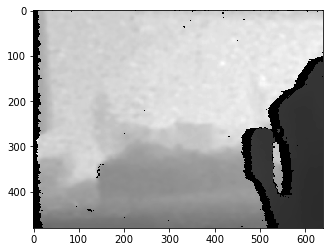

In [32]:
df = np.array(frame.get_data())
plt.imshow(df, cmap='gray')

In [35]:
def toKoord(dist_array, cam_pitch=0, cam_yaw=0, cam_position=[0, 0, 0]):
    """
    :return 
    realSense d435 depthcam -> 86°x57° FOV
    :param dist_array: array of distances in mm 
    :param cam_pitch: camara pitch/drone tilt
    :param cam_yaw: yaw of camera/drone
    :param cam_position: gps location of camera
    """
    # reducing the size of the array to to conserve computing power
    dist_array = max_reBin(dist_array, (120, 160))
    vec_arr = []
    for j in range(120):
        for i in range(160):
            if dist_array[j][i] != 0.0:
                alpha = (47.0 + (2*i + 1)*(43.0/160)) # Grad X|Y
                beta = (28.5 - (2*j + 1)*(28.5/120)) # Grad Y|Z
                r = dist_array[j][i]
                vec_arr.append(np.array([r*cos(radians(beta))*sin(radians(alpha)),
                                r*cos(radians(beta))*cos(radians(alpha)),
                                r*sin(radians(beta))]))
    trans_yaw = np.array([
        [cos(radians(cam_yaw)),-sin(radians(cam_yaw)),0],
        [sin(radians(cam_yaw)),cos(radians(cam_yaw)), 0],
        [0,0,1]
    ])
    trans_pitch = np.array([
        [cos(radians(cam_pitch)),0,sin(radians(cam_pitch))],
        [0,1,0],
        [-sin(radians(cam_pitch)),0,cos(radians(cam_pitch))],
    ])
    
    # np.matmul statt @, damit wir nicht abhängig von Python 3.5+ sind
    res = [np.matmul(np.matmul(trans_yaw,trans_pitch),x) + cam_position for x in vec_arr if (-150 < np.matmul(np.matmul(trans_yaw,trans_pitch), x)[2] < 150)]  
    return np.array(res)

#df = np.ones((120,160))*1000
cor = toKoord(dist_array=df,cam_pitch=0,cam_yaw=0)
cor

array([[ 562.75336382, -455.20070636,  149.07034731],
       [ 557.70266546, -459.83678458,  148.8686283 ],
       [ 552.61457667, -464.41821641,  148.66690929],
       ...,
       [ 444.90716248, -410.99802572, -145.83291681],
       [ 456.13132106, -390.69297247, -149.88068325],
       [ 452.44615653, -394.95475213, -149.88068325]])

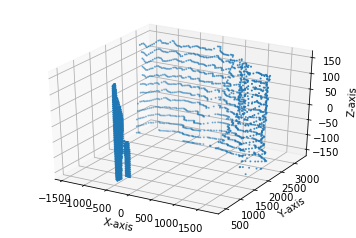

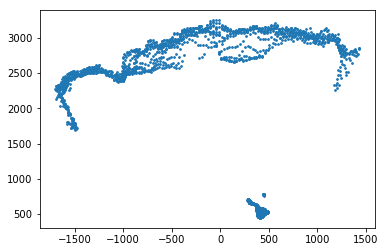

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
cor = cor.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cor[1], cor[0], cor[2], marker='o', s=1)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()
plt.close()

plt.scatter(-cor[1], cor[0], s=3);

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(b[0], b[2], b[1], marker='o', s=1)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()
plt.close()